In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. 目的
用简单且强大的LC模型, 尝试二分类预测。

- 数据分析
- 异常数据处理
- 特征选择

欢迎加微信交流: ITlooker

# 2. 过程
## 2.1 数据分析

> 字段说明

|变量    |定义|  枚举值|
 | --------   | -----:   | :----: |
| survival |   Survival  | 0 = No, 1 = Yes
| pclass  |Ticket class |   1 = 1st, 2 = 2nd, 3 = 3rd
| sex | Sex  |
|Age |Age in years    |
|sibsp  | # of siblings / spouses aboard the Titanic  |堂兄弟/妹个数
|parch|   # of parents / children aboard the Titanic  |父母与小孩个数
|ticket  |Ticket number   |
|fare |   Passenger fare  | the money that you pay for a journey in a vehicle 
|cabin|   Cabin number    | 船舱编号
|embarked    |Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton| 出发的港口

In [102]:
# 下面是我自己本地数据的路径, 你需要替换成自己电脑上数据的路径:
train_path = '/tmp/train.csv'
test_path = '/tmp/test.csv'
df_test = pd.read_csv(test_path)
df_train = pd.read_csv(train_path)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 2.1.1 整体查看

In [103]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2.1.2 各属性分布

** 连续值转离散 **

In [104]:
# 针对 Age 和 Fare, 进行连续值转离散操作, 实际操作上就是把值分段:
import math
def continueToGroup(df, column_name, group_num):
    '''
    df: DataFrame
    column_name: 被分段的字段
    group_num: 希望被划分的组数
    '''
    # 注意: pd.cut函数默认被分段的区间是左开右闭, 如: (0,10]
    # 所以min需要略低一些, 这样不会漏数据
    min_v = math.floor(df[column_name].min()) - 0.1
    max_v = math.ceil(df[column_name].max()*1.0)  # math.ceil要求参数为float类型
    step = math.ceil((max_v - min_v) / group_num)
    
    # 自己测试下 np.arange(0,10,1) 就会知道为啥 max_v+step 最后要加step
    df[column_name+'_group'] = pd.cut(df[column_name], np.arange(min_v, max_v+step, step))

# 连续值变离散 字段分组:
continueToGroup(df_train, 'Fare', 5)
continueToGroup(df_train, 'Age', 10)
continueToGroup(df_test, 'Fare', 5)
continueToGroup(df_test, 'Age', 10)

** 各特征的分布** 

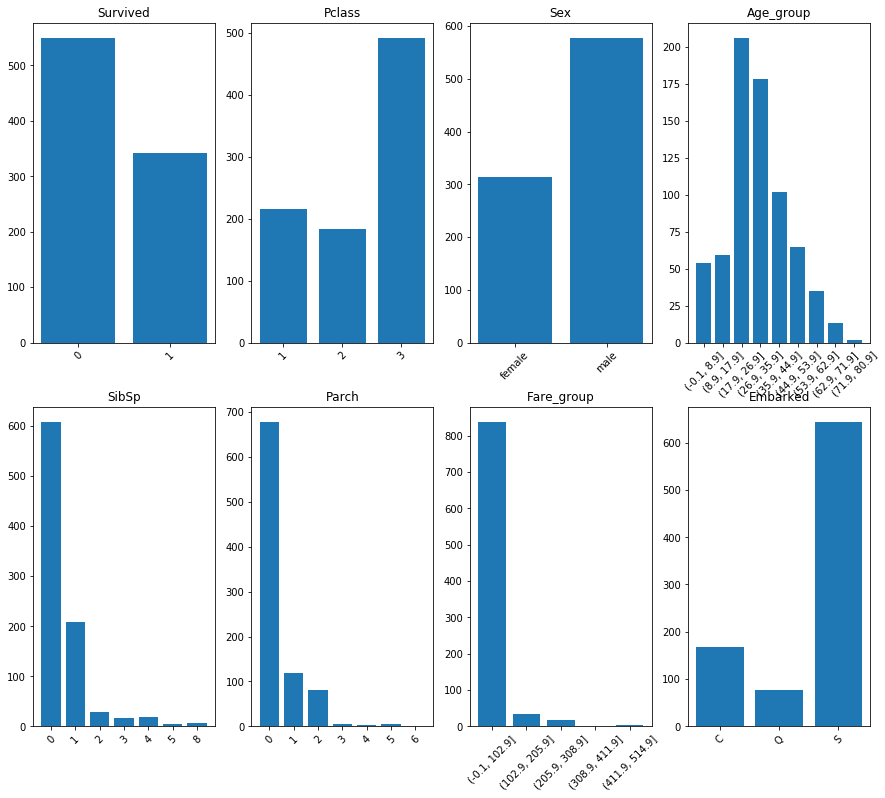

In [105]:
# 字段包括: Survived, Sex, Pclass, Age_group, SibSp, Parch, Fare_group, Embarked
# 每个单个绘图工作重复, 所以写个绘图函数, 批量绘图，刷刷刷! 分布看的一清二楚!
def fun_distributed(df, column_name):
    df_res = df.groupby(column_name).count()['PassengerId'].reset_index()
    # 柱状图x轴仅接受float类型，如果要显示str的x轴标签，需要映射处理下
    x_names = df_res[column_name].values
    x_list = range(len(x_names))
    plt.xticks(x_list, x_names, rotation=45)
    
    y_list = df_res['PassengerId'].values
    plt.title(column_name)
    plt.bar(x_list, y_list)
    plt.legend()

column_list = ['Survived', 'Pclass', 'Sex', 'Age_group','SibSp', 'Parch', 'Fare_group', 'Embarked']
# 根据单个字段批量绘图
def draw_all_columns(df, columns):
    fig = plt.figure(figsize=(15,20))
    for i in range(len(columns)):
        plt.subplot(3,4,i+1)
        fun_distributed(df, columns[i])
    
draw_all_columns(df_train, columns=column_list)

** 各属性TGI指数查看 **

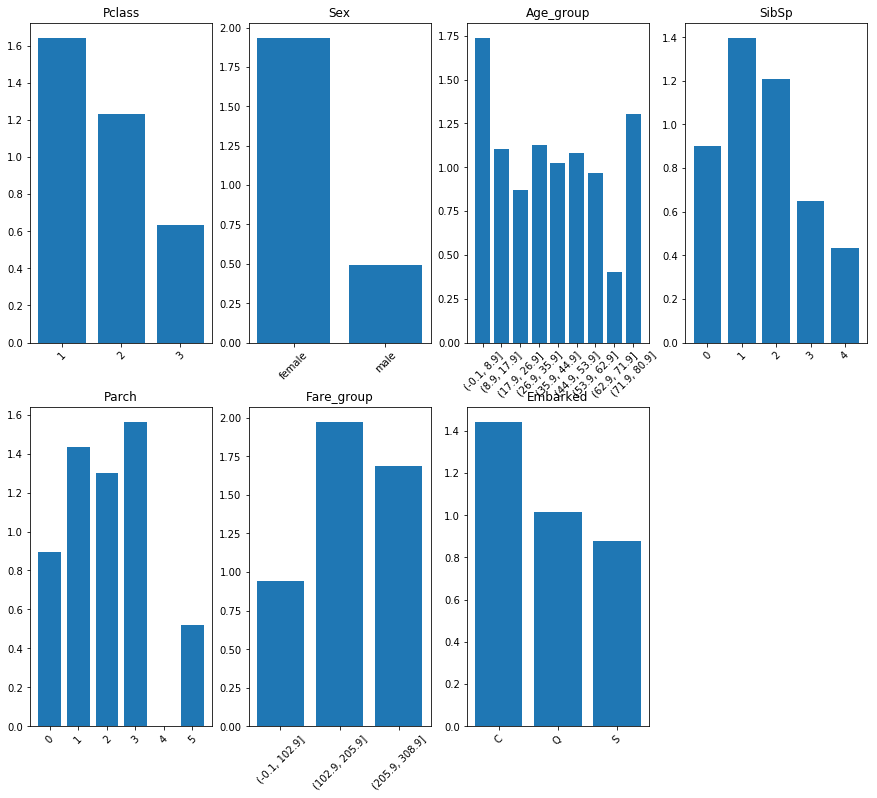

In [106]:
# 计算平均幸存率
survived_percent = 1.0*df_train.Survived[df_train.Survived==1].count() / df_train.Survived.count()

# tgi比例计算
def fun_tgi(df, column_name, scale=survived_percent):
    df_res = df.groupby(['Survived', column_name]).count()['PassengerId'].reset_index()
    df_pivot = pd.pivot_table(df_res, values='PassengerId', columns='Survived', index=column_name, aggfunc=np.sum)
    df_pivot['total']=df_pivot[0] + df_pivot[1]
    df_pivot['percent']=df_pivot[1]/df_pivot['total']
    # 柱状图x轴仅接受float类型，如果要显示str的x轴标签，需要映射处理下
    x_names = df_pivot.index.values
    x_list = range(len(x_names))
    plt.xticks(x_list, x_names, rotation=45)
    
    y_list = df_pivot['percent'] / scale
    plt.title(column_name)
    plt.bar(x_list, y_list)
    plt.legend()

column_list = ['Pclass', 'Sex', 'Age_group','SibSp', 'Parch', 'Fare_group', 'Embarked']
# 根据单个字段批量绘图
def draw_tgi_all_columns(df, columns):
    fig = plt.figure(figsize=(15,20))
    for i in range(len(columns)):
        plt.subplot(3,4,i+1)
        fun_tgi(df, columns[i])
        
draw_tgi_all_columns(df_train, column_list)

### 2.1.3 空值处理

In [107]:
# 批量检查空值
def check_null(df):
    for i in df.columns:
        df_col = df[df[i].isnull()]
        if df_col.size>0 and i != 'Cabin' and i != 'Age_group' and i!='Fare_group':
            print(df_col)

# 针对三个字段的空值进行填充
# 填充方式很多, 这里按中位数填充
df_train.Embarked.fillna('C', inplace=True)
df_train.Fare.fillna(df_train.Fare.median(), inplace=True)
df_train.Age.fillna(df_train.Age.median(), inplace=True)

df_test.Embarked.fillna('C', inplace=True)
df_test.Fare.fillna(df_test.Fare.median(), inplace=True)
df_test.Age.fillna(df_test.Age.median(), inplace=True)

# 检查空值处理后有误
check_null(df_train)
check_null(df_test)

### 2.1.4 异常值查看

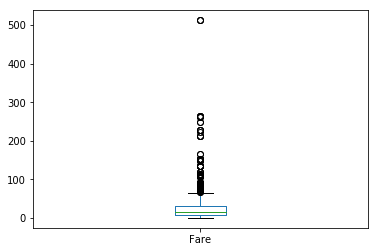

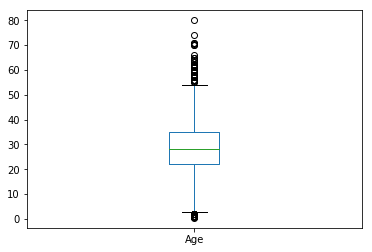

In [108]:
# 查看Fare和Age两个连续值的箱图, 观看异常值分布
df_train.Fare.plot(kind='box')
plt.show()
df_train.Age.plot(kind='box')
plt.show()

** 过滤掉异常值 **

In [109]:
df_train = df_train[(df_train.Age<=50) & (df_train.Fare<=50)]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 688 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    688 non-null int64
Survived       688 non-null int64
Pclass         688 non-null int64
Name           688 non-null object
Sex            688 non-null object
Age            688 non-null float64
SibSp          688 non-null int64
Parch          688 non-null int64
Ticket         688 non-null object
Fare           688 non-null float64
Cabin          69 non-null object
Embarked       688 non-null object
Fare_group     688 non-null category
Age_group      533 non-null category
dtypes: category(2), float64(2), int64(5), object(5)
memory usage: 71.4+ KB


## 2.2 数据处理(特征处理)

### 2.2.1 连续值转离散

In [110]:
# 将连续值转化为Label
import math
def continueToGroup(df, column_name, group_num):
    min_v = math.floor(df[column_name].min()) - 0.1
    max_v = math.ceil(df[column_name].max()*1.0)
    step = math.ceil((max_v - min_v) / group_num)
    # 注意: 开闭区间, 所以min和max都要扩大才能cover所有值
    df[column_name+'_group'] = pd.cut(df[column_name], np.arange(min_v, max_v+step, step))
 
# 将离散Label转化为数字   
from sklearn import preprocessing
def groupToNum(df, column_name):
    le = preprocessing.LabelEncoder()
    le.fit(df[column_name])
    new_column_name = column_name+'_toNum'
    df[new_column_name] = le.transform(df[column_name])
    return new_column_name

# 连续值变离散 字段分组:
continueToGroup(df_train, 'Fare', 5)
continueToGroup(df_train, 'Age', 10)
continueToGroup(df_test, 'Fare', 5)
continueToGroup(df_test, 'Age', 10)

# 开始操作
groupToNum(df_train, 'Fare_group')
groupToNum(df_train, 'Age_group')
groupToNum(df_test, 'Fare_group')
groupToNum(df_test, 'Age_group')

'Age_group_toNum'

### 2.2.2 分类别的离散值进行one-hot编码

In [111]:
# one-hot 编码
def get_dummies_all(df, column_list):
    res_list = []
    for c in column_list:
        res_list.append(pd.get_dummies(df[c], prefix= c))
    return pd.concat(res_list, axis=1)

c_list = ['Pclass', 'Sex']

df_tmp = get_dummies_all(df_train, column_list=c_list)
df_train = pd.concat([df_train, df_tmp], axis=1)

df_tmp = get_dummies_all(df_test, column_list=c_list)
df_test = pd.concat([ df_test, df_tmp] , axis=1)

In [112]:
print(df_train.shape)
print(df_test.shape)

(688, 21)
(418, 20)


## 2.3 训练预测

### 2.3.1 单个LR训练预测

In [113]:
from sklearn.linear_model import LogisticRegression
# 经过one hot 编码后的列名, 过滤要进入训练集的特征
regex_str = 'Survived|Age_group_toNum.*|Fare_group_toNum.*|SibSp|Parch|Sex_.*male|Pclass_.*'
df_train_filter = df_train.filter(regex=regex_str)
df_test_filter = df_test.filter(regex=regex_str)

X_train_list = df_train_filter.columns.values[2:]
X_test_list = df_test_filter.columns.values[1:]
# 生成训练数据
X = df_train_filter[X_train_list]
y = df_train_filter['Survived']
# 待预测数据
X_predict = df_test_filter[X_test_list]
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X,y)
# 自己先看下训练评分
clf.score(X, y)

0.79360465116279066

### 2.3.2 抽样放回多次LR训练预测

In [114]:
# BaggingRegressor, 即对训练数据抽样N次, 每次都用LR进行预测, 融合最终结果
from sklearn.ensemble import BaggingRegressor
clf = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.5, max_features=1.0, bootstrap=True, bootstrap_features=True, n_jobs=1)
bagging_clf.fit(X, y)
# 含义: Returns the coefficient of determination R^2 of the prediction.
bagging_clf.score(X, y)

0.21309536637931029

## 2.4 交叉验证

### 2.4.1 交叉验证的分值

In [115]:
from sklearn.model_selection import cross_val_score
regex_str = 'Survived|Age_group_toNum.*|Fare_group_toNum.*|SibSp|Parch|HasCabin_False|HasCabin_False|Sex_.*male|Pclass_.*|Mother_.*|isChild_.*|name2_Ms|name2_Mr|name2_Miss|Family.*'

all_data = df_train_filter.filter(regex=regex_str)
X = all_data.as_matrix()[:,1:]
y = all_data.as_matrix()[:,0]
clf = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
print(cross_validation.cross_val_score(clf, X, y, cv=5))

[ 0.79710145  0.77536232  0.80434783  0.7826087   0.83088235]


### 2.4.2 bad case分析

In [116]:
# 分割数据，按照 训练数据:cv数据 = 7:3的比例
from sklearn.model_selection import train_test_split
split_train, split_cv = train_test_split(df_train, test_size=0.3, random_state=0)
regex_str = 'Survived|Age_group_toNum.*|Fare_group_toNum.*|SibSp|Parch|HasCabin_False|HasCabin_False|Sex_.*male|Pclass_.*'

all_data = split_train.filter(regex=regex_str)
all_data.head()
# 生成模型
clf = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(all_data.as_matrix()[:,1:], all_data.as_matrix()[:,0])

# 对cross validation数据进行预测
cv_df = split_cv.filter(regex=regex_str)
predictions = clf.predict(cv_df.as_matrix()[:,1:])

origin_data_train = pd.read_csv(train_path)
# split_cv[predictions != cv_df.as_matrix()[:,0]].head()
# origin_data_train['PassengerId'].isin(split_cv[predictions != cv_df.as_matrix()[:,0]]['PassengerId'].values)
bad_cases = origin_data_train.loc[origin_data_train['PassengerId'].isin(split_cv[predictions != cv_df.as_matrix()[:,0]]['PassengerId'].values)]
bad_cases.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,38.000000,38.000000,38.000000,29.000000,38.000000,38.000000,38.000000
mean,462.842105,0.447368,2.657895,25.000000,0.368421,0.605263,15.274563
std,280.729121,0.503897,0.627148,10.938138,0.674679,1.326232,9.818998
min,15.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,229.250000,0.000000,2.250000,20.000000,0.000000,0.000000,7.864600
50%,531.000000,0.000000,3.000000,25.000000,0.000000,0.000000,13.000000
75%,665.250000,1.000000,3.000000,29.000000,1.000000,0.750000,19.775000
max,890.000000,1.000000,3.000000,45.000000,3.000000,5.000000,39.687500


## 2.5 特征优化

### 2.5.1 提取name中称谓词

In [117]:
# 提取姓名中的称谓: 如 Mr. Miss. 等
df_train['name2'] = df_train.Name.apply(lambda x: x.split(",")[1].split('.')[0].strip())
df_test['name2'] = df_test.Name.apply(lambda x: x.split(",")[1].split('.')[0].strip())

### 2.5.2 提取Cabin数字

In [118]:
# 仓位Cabin虽然确实比较多, 但可以尝试用下仓位的数字部分
# 标记是否缺失
df_train['HasCabin'] =  df_train['Cabin'].isnull()
df_test['HasCabin'] =  df_test['Cabin'].isnull()
# 不缺失的值，取出其中数字部分
import re
p= re.compile(r"[a-zA-Z ]")
pNum= re.compile(r"[0-9]")
def chooseNumFromCabin(cabinStr):
    if cabinStr is None:
        return 0
    try:
        res = pNum.findall(str(cabinStr))
    except TypeError:
        print(cabinStr, type(cabinStr))
    # 即: 如果字符串中没有数字直接返回0
    if len(res)==0:
        return 0
    c_list = p.split(cabinStr)
    c_list.sort(reverse=True)
    return c_list[0]


df_train['Cabin_No'] = df_train.Cabin.apply(lambda x: chooseNumFromCabin(x))
df_train['Cabin_No'] = df_train.Cabin_No.astype('float')
df_test['Cabin_No'] = df_test.Cabin.apply(lambda x: chooseNumFromCabin(x))
df_test['Cabin_No'] = df_test.Cabin_No.astype('float')

### 2.5.3 生成是否是孩子

In [119]:
df_train['isChild'] = df_train.Age<12
df_test['isChild'] = df_test.Age<12

### 2.5.3 生成是否是母亲

In [120]:
df_train['Mother'] = (df_train.Parch>1) & (df_train.name2=='Mrs')
df_test['Mother'] = (df_test.Parch>1) & (df_test.name2=='Mrs')

### 2.5.4 生成家庭成员数

In [121]:
df_train['Family_size'] = df_train.Parch + df_train.SibSp
df_test['Family_size'] = df_test.Parch + df_test.SibSp

### 2.5.5 重新抽取特征预测

In [122]:
c_list = ['Pclass', 'Sex', 'name2', 'HasCabin', 'Mother', 'isChild']

df_tmp = get_dummies_all(df_train, column_list=c_list)
df_train_filter = pd.concat([df_train, df_tmp], axis=1)

df_tmp = get_dummies_all(df_test, column_list=c_list)
df_test_filter = pd.concat([ df_test, df_tmp] , axis=1)

regex_str = 'Survived|Age_group_toNum.*|Fare_group_toNum.*|SibSp|Parch|HasCabin_False|HasCabin_False|Sex_.*male|Pclass_.*|Mother_.*|isChild_.*|name2_Ms|name2_Mr|name2_Miss|Family.*'
all_data = df_train.filter(regex=regex_str)
X =  all_data.as_matrix()[:,1:]
y = all_data.as_matrix()[:,0]
X_predict = df_test.filter(regex=regex_str)


clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X,y)
clf.score(X, y)

0.8066860465116279

In [123]:
# BaggingRegressor, 即对训练数据抽样N次, 每次都用LR进行预测, 融合最终结果
from sklearn.ensemble import BaggingRegressor
clf = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.5, max_features=1.0, bootstrap=True, bootstrap_features=True, n_jobs=1)
bagging_clf.fit(X, y)
# 含义: Returns the coefficient of determination R^2 of the prediction.
bagging_clf.score(X, y)

0.25251423953201968

# 3. 特别感谢
[寒小阳:机器学习系列(3)_逻辑回归应用之Kaggle泰坦尼克之灾](https://blog.csdn.net/han_xiaoyang/article/details/49797143)

# 4.关于自己

- 微信公众号: workindata
- 个人微信号: ITlooker
- 知乎: https://zhuanlan.zhihu.com/ITlooker